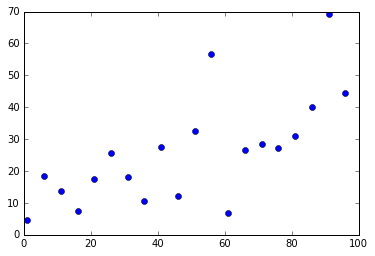

In [2]:
# module import
import pystan
import numpy as np
import pylab as py
import pandas as pd
%matplotlib inline
 
## data simulation
x = np.arange(1, 100, 5)
y = 2.5 + .5 * x + np.random.randn(20) * 10
 
# get number of observations
N = len(x)
 
# plot the data
py.plot(x,y, 'o')
py.show()


In [5]:
# STAN model (this is the most important part)
regress_code = """
data {
 int<lower = 0> N; // number of observations
 real y[N]; // response variable
 real x[N]; // predictor variable
}
parameters {
 real a; // intercept
 real b; // slope
 real<lower=0> sigma; // standard deviation
}
transformed parameters {
 real mu[N]; // fitted values
 
for(i in 1:N)
 mu[i] <- a + b*x[i];
}
model {
 y ~ normal(mu, sigma);
}
"""
 
# make a dictionary containing all data to be passed to STAN
regress_dat = {'x': x,
 'y': y,
 'N': N}
 
# Fit the model
fit = pystan.stan(model_code=regress_code, data=regress_dat,
 iter=5000, chains=4)
 
# model summary
print (fit)

/home/yannick/bin/anaconda3/envs/py35/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/yannick/bin/anaconda3/envs/py35/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/yannick/bin/anaconda3/envs/py35/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/yannick/bin/anaconda3/envs/py35/lib/python3.5/multiprocessing/reduc

Inference for Stan model: anon_model_f6ebce9f03467a5ca70e280e6b25c124.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a        6.83    0.06   6.01  -4.94   2.92   6.81  10.68  18.95  10000    1.0
b         0.4  1.1e-3   0.11   0.18   0.33   0.39   0.46   0.61  10000    1.0
sigma   13.45    0.03   2.52   9.62  11.66  13.09  14.81  19.33  10000    1.0
mu[0]    7.22    0.06   5.92  -4.36   3.38   7.22  11.01  19.15  10000    1.0
mu[1]     9.2    0.05   5.47  -1.48   5.63   9.17   12.7  20.23  10000    1.0
mu[2]   11.17    0.05   5.03   1.29    7.9  11.16   14.4  21.28  10000    1.0
mu[3]   13.15    0.05   4.62   4.01  10.14  13.14  16.14  22.38  10000    1.0
mu[4]   15.13    0.04   4.23   6.75   12.4  15.12  17.87  23.58  10000    1.0
mu[5]    17.1    0.04   3.88   9.38   14.6   17.1   19.6  24.84  10000    1.0
mu[6]   19.08    0.04   3.57  

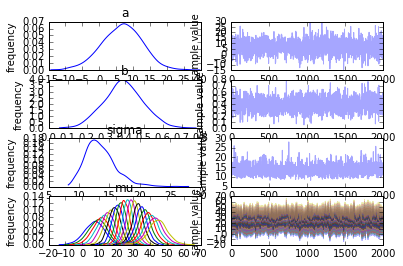

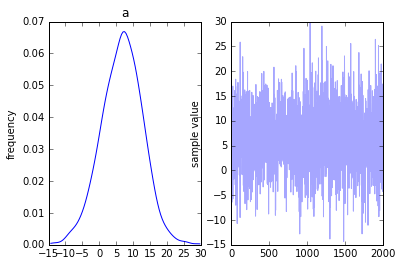

IndexError: index out of bounds

In [4]:
# show a traceplot of ALL parameters. This is a bear if you have many
fit.traceplot()
py.show()
 
# Instead, show a traceplot for single parameter
fit.plot(['a'])
py.show()
 
##### PREDICTION ####
 
# make a dataframe of parameter estimates for all chains
params = pd.DataFrame({'a': fit.extract('a', permuted=True), 'b': fit.extract('b', permuted=True)})
 
# next, make a prediction function. Making a function makes every step following this 10 times easier
def stanPred(p):
 fitted = p[0] + p[1] * predX
 return pd.Series({'fitted': fitted})
 
# make a prediction vector (the values of X for which you want to predict)
predX = np.arange(1, 100)
 
# get the median parameter estimates
medParam = params.median()
# predict
yhat = stanPred(medParam)
 
# get the predicted values for each chain. This is super convenient in pandas because
# it is possible to have a single column where each element is a list
chainPreds = params.apply(stanPred, axis = 1)
 
## PLOTTING
 
# create a random index for chain sampling
idx = np.random.choice(1999, 50)
# plot each chain. chainPreds.iloc[i, 0] gets predicted values from the ith set of parameter estimates
for i in range(len(idx)):
 py.plot(predX, chainPreds.iloc[idx[i], 0], color='lightgrey')
 
# original data
py.plot(x, y, 'ko')
# fitted values
py.plot(predX, yhat['fitted'], 'k')
 
# supplementals
py.xlabel('X')
py.ylabel('Y')
 
py.show()